<a href="https://colab.research.google.com/github/Konstantinos72002/Ai-assignments/blob/main/simple_autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms

import numpy as np
import matplotlib.pyplot as plt

In [2]:
transform = transforms.ToTensor()

In [3]:
train_dataset = torchvision.datasets.MNIST(root = "./data" , train = True , download = True ,  transform = transform)
valid_dataset = torchvision.datasets.MNIST(root = "./data" , train = False , download = True ,  transform = transform)

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 17.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 479kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.79MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.72MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [26]:
train_dl = torch.utils.data.DataLoader(train_dataset , batch_size = 100)
valid_dl = torch.utils.data.DataLoader(valid_dataset , batch_size = 100)

In [5]:
class Encoder(nn.Module):
  def __init__(self , input_size = 28*28 , hidden_size1 = 128 , hidden_size2 = 16 , z_dim = 2):
    super().__init__()
    self.fc1 = nn.Linear(input_size , hidden_size1)
    self.fc2 = nn.Linear(hidden_size1 , hidden_size2)
    self.fc3 = nn.Linear(hidden_size2 , z_dim)
    self.relu = nn.ReLU()
  def forward(self , x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = self.fc3(x)
    return x

In [6]:
class Decoder(nn.Module):
  def __init__(self , output_size = 28*28 , hidden_size1 = 128 , hidden_size2 = 16 , z_dim = 2):
    super().__init__()
    self.fc1 = nn.Linear(z_dim , hidden_size2)
    self.fc2 = nn.Linear(hidden_size2 , hidden_size1)
    self.fc3 = nn.Linear(hidden_size1 , output_size)
    self.relu = nn.ReLU()
  def forward(self , x):
    x = self.relu(self.fc1(x))
    x = self.relu(self.fc2(x))
    x = torch.sigmoid(self.fc3(x))
    return x

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [8]:
enc = Encoder().to(device)
dec = Decoder().to(device)

In [9]:
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

In [10]:
train_loss = []

In [11]:
num_epochs = 200

In [12]:
for epoch in range(num_epochs):
  train_epoch_loss = 0
  for (imgs , _) in train_dl:
    imgs = imgs.to(device)
    #100 , 1 , 28 , 28 ---> (100 , 28*28)
    imgs = imgs.flatten(1)
    latents = enc(imgs)
    output = dec(latents)
    loss = loss_fn(output , imgs)
    train_epoch_loss += loss.cpu().detach().numpy()
    optimizer_enc.zero_grad()
    optimizer_dec.zero_grad()
    loss.backward()
    optimizer_enc.step()
    optimizer_dec.step()
  train_loss.append(train_epoch_loss)

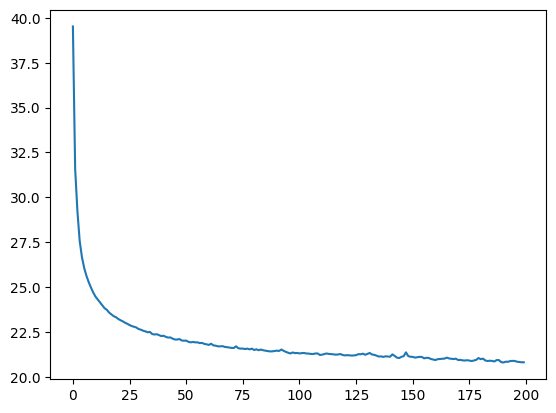

In [13]:
plt.plot(train_loss)

In [14]:
values = None
all_labels = []

with torch.no_grad():
  for (imgs , labels) in train_dl:
    imgs = imgs.to(device)
    imgs = imgs.flatten(1)
    all_labels.extend(list(labels.numpy()))
    latents = enc(imgs)
    if values is None:
      values = latents.cpu()
    else:
      values = torch.vstack([values , latents.cpu()])

In [15]:
values.shape

torch.Size([60000, 2])

In [16]:
cmap = plt.get_cmap('viridis', 10)

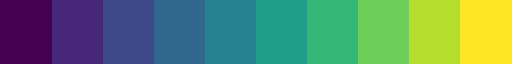

In [17]:
cmap

In [18]:
all_labels = np.array(all_labels)
values = values.numpy()

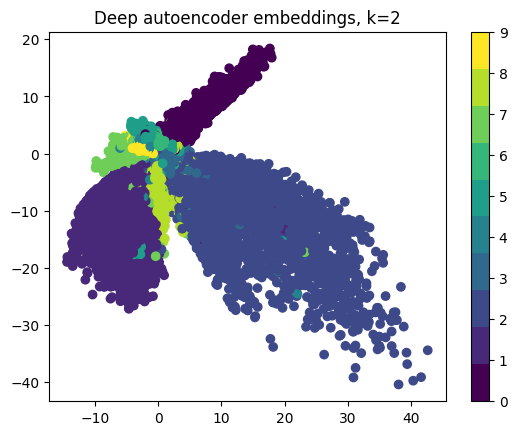

In [19]:
pc = plt.scatter(values[: , 0] , values[: , 1] , c = all_labels , cmap = cmap)
plt.title('Deep autoencoder embeddings, k=2')
plt.colorbar(pc)

In [20]:
all_means = {}
for i in range(10):
  inds = np.argwhere(all_labels == i)
  num_latents = values[inds].squeeze()
  mean = num_latents.mean(axis = 0)
  all_means[i] = (mean[0] , mean[1])


In [21]:
all_means

{0: (3.4798446, 3.987187),
 1: (-5.6559887, -9.121437),
 2: (9.766792, -8.0673895),
 3: (1.1787238, -0.96124023),
 4: (-1.080414, 0.42927456),
 5: (0.057559796, 0.2824399),
 6: (0.16498864, 1.411388),
 7: (-3.0671449, -0.516172),
 8: (-0.022059796, -2.2141292),
 9: (-1.4230891, 0.15925369)}

In [22]:
torch.Tensor(all_means[0])[None , ...].shape

torch.Size([1, 2])

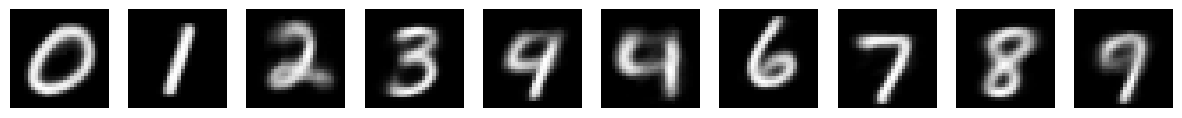

In [23]:
fig, axs = plt.subplots(1, 10, figsize=(15, 2))  # 1 row, 10 columns

# Loop through and generate each image, plotting them in the grid
for i in range(10):
    with torch.no_grad():
        pred = dec(torch.Tensor(all_means[i])[None, ...].to(device)).cpu()
        img = transforms.ToPILImage()(pred.reshape(1, 28, 28))  # Reshape to 1x28x28 for grayscale image
        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')  # Turn off axis for cleaner look

plt.show()

In [23]:
train_labels = train_dataset.targets
valid_labels = valid_dataset.targets

In [ ]:
with torch.no_grad():
    for images, targets in valid_dl:
        images = images.view(images.size(0), -1)  # Flatten the images
        latent = encoder(images)  # Get the latent representation
        latent_representations.append(latent)
        labels.append(targets)